In [1]:
!pip install opendatasets


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Прогнозирование потребления электроэнгергии

Целью данной работы является построение модели для прогнозирования потребления электроэнергии.

На основе имеющихся исторических данных об электропотреблении составим прогноз на предстоящую неделю.

У нас имеется набор данных многомерного временного ряда, который описывает потребление электроэнергии для одного домохозяйства в течение четырех лет.

Данные были собраны в период с декабря 2006 года по ноябрь 2010; замеры потребления электроэнергии выполнялись каждую минуту.

Помимо даты и времени набор данных состоит из семи переменных:
-	global_active_power - общая активная мощность, потребляемая жилым домом (измеряется в киловаттах).
-	global_reactive_power - общая реактивная мощность, потребляемая жилым домом (измеряется в киловаттах).
-	voltage - среднее напряжение (измеряется в вольтах).
-	global_intensity - среднее значение силы тока (измеряется в амперах).
-	sub_metering_1 - активная энергия потребления кухонной комнаты (измеряется в ватт-часах активной энергии).
-	sub_metering_2 - активная энергия потребления прачечной (измеряется в ватт-часах активной энергии).
-	sub_metering_3 - активная энергия потребления систем климат-контроля (измеряется в ватт-часах активной энергии).

Активная и реактивная энергия относятся к техническим деталям переменного тока (активная мощность это и есть потребляемая мощность, за которую мы, собственно, платим по счётчику).


## Исследовательский анализ и предобработка данных

In [2]:
# импортируем необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import opendatasets as od

from numpy import isnan
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# загружаем данные с kaggle
od.download(
    "https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set")

Skipping, found downloaded files in ".\electric-power-consumption-data-set" (use force=True to force download)


In [4]:
# открываем файл
df = pd.read_csv('electric-power-consumption-data-set/\household_power_consumption.txt', 
                 sep=';', header=0, low_memory=False, infer_datetime_format=True, 
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])


In [5]:
# выводим первые 5 строк
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
# посмотрим временной период
print('Начало измерений', df.index.min())
print('Конец измерений', df.index.max())
print('Временной диапазон', df.index.max() - df.index.min())

Начало измерений 2006-12-16 17:24:00
Конец измерений 2010-11-26 21:02:00
Временной диапазон 1441 days 03:38:00


Видим что в нашем распоряжении данные о потреблении электроэнергии за 4 года с декабря 2006 по ноябрь 2010 года.

In [7]:
#приводим заголовки столбцов к строчному формату
df.columns = df.columns.str.lower()

In [8]:
# вывод общей информации 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    object 
 1   global_reactive_power  object 
 2   voltage                object 
 3   global_intensity       object 
 4   sub_metering_1         object 
 5   sub_metering_2         object 
 6   sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [9]:
#вывод описательной статистики
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
global_active_power,2075259,4187,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_reactive_power,2075259,533,0.000,481561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voltage,2075259,2838,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_intensity,2075259,222,1.000,172785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_1,2075259,89,0.000,1880175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_2,2075259,82,0.000,1436830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_3,2049280.0,NaN,NaN,NaN,6.458447,8.437154,0.0,0.0,1.0,17.0,31.0


In [10]:
# заменяем пропуски
df.replace('?', np.nan, inplace=True) 

In [11]:
# приводим данные к числовому формату
df= df.astype('float') 

In [12]:
#вывод описательной статистики
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


In [13]:
#проверка пропусков
df.isna().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

Заменим пропуски тем же значением, которое было в заданное время один день назад

In [14]:
#функция заполнения пропущенных значений
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [15]:
#применяем функцию
fill_missing(df.values)

In [16]:
#проверка пропусков
df.isna().sum()

global_active_power      0
global_reactive_power    0
voltage                  0
global_intensity         0
sub_metering_1           0
sub_metering_2           0
sub_metering_3           0
dtype: int64

С учётом поставленной задачи было бы полезным уменьшить выборку с поминутных замеров потребления электроэнергии до ежедневных значений

In [17]:
# объединяем данные по дням и считаем сумму наблюдений за каждый день
daily_groups = df.resample('D') 
daily_df = daily_groups.sum() 
daily_df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [18]:
# удаялем неинформативные толбцы
daily_df = daily_df.drop(['global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3'], axis = 1)

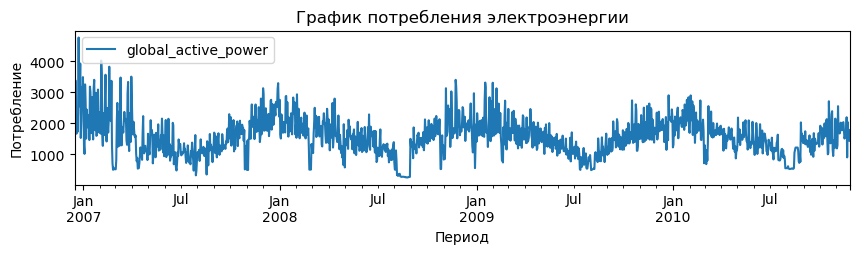

In [19]:
# строим график потребления э/э
plt.figure(figsize = (10,2))
daily_df['global_active_power'].plot() 
plt.legend(title = '', loc = 'upper left', fontsize = 10)
plt.ylabel('Потребление', fontsize = 10)
plt.xlabel('Период', fontsize = 10)
plt.title('График потребления электроэнергии', fontsize = 12)
plt.show()

Чтобы лучше понимать временной ряд,  разложим его на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.

In [20]:
# проверяем, что индекс монотонный
daily_df.index.is_monotonic

True

In [21]:
# разложим временной ряд на компоненты
decomposed = seasonal_decompose(daily_df)

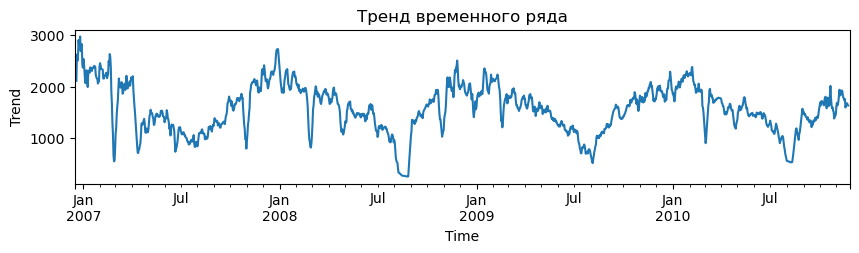

In [22]:
# визуализируем данные
decomposed.trend.plot(figsize=(10, 2))
plt.title('Тренд временного ряда')
plt.xlabel("Time")
plt.ylabel("Trend")
plt.show()

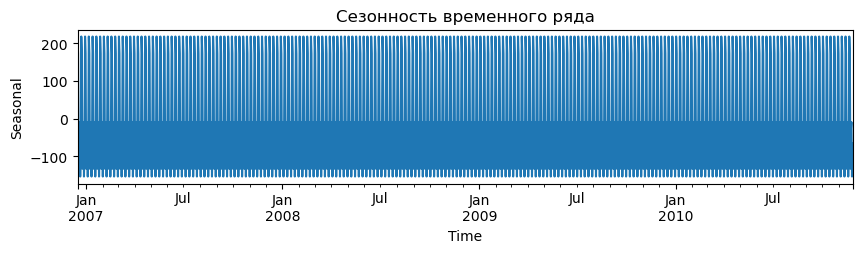

In [23]:
# визуализируем данные
decomposed.seasonal.plot(figsize=(10, 2))
plt.title('Сезонность временного ряда')
plt.xlabel("Time")
plt.ylabel("Seasonal")
plt.show()

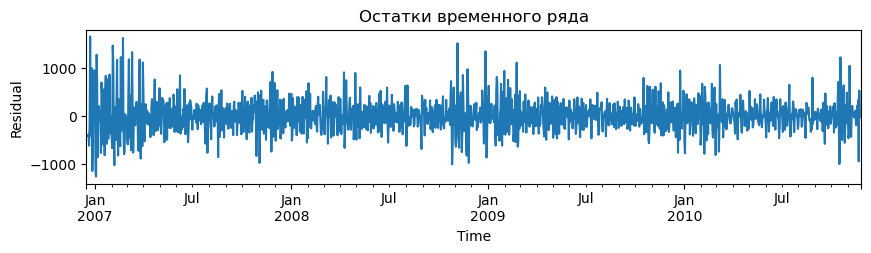

In [24]:
# визуализируем данные
decomposed.resid.plot(figsize=(10, 2))
plt.title('Остатки временного ряда')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

Можно заметить явно выраженную сезонность - снижение потребления в течение летних месяцев, и  увеличение потребления в зимние месяцы. 

Перед тем, как перейти к моделированию, стоит спроверить стационарность временного ряда. Для оценки стационарности временного ряда применим тест Дики-Фуллера

В данном случае гипотезы звучат следующим образом:

- Нулевая гипотеза предполагает, что ряд не стационарен
- Альтернативная гипотеза предполагает, что ряд стационарен

Применим этот тест используя пороговое значение, равное 0,05 (5%).


In [25]:
# оценка стационарности

alpha = 0.05

# передадим ей столбец с данными и поместим результат в adf_test
adf_test = adfuller(daily_df['global_active_power'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))
if float(adf_test[1]) < alpha:
    print("Отвергаем нулевую гипотезу, ряд стационарен")
else:
    print("Не получилось отвергнуть нулевую гипотезу, ряд не стационарен")

p-value = 0.0041500920445575835
Отвергаем нулевую гипотезу, ряд стационарен


## Обучение

Создадим признаки для горизонта прогнозирования в один шаг.

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['global_active_power'].shift(lag)
        
    # Добавление признака скользящего среднего
    data['rolling_mean'] = data['global_active_power'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [27]:
# применяем функцию, параметры подобраны опытным путем
daily_df = make_features(daily_df, 30, 7)

In [28]:
# выводим первые 5 строк
daily_df.head()

,global_active_power,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16,1209.176,2006,12,16,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-17,3390.460,2006,12,17,6,1209.176,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-18,2203.826,2006,12,18,0,3390.460,1209.176,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-19,1666.194,2006,12,19,1,2203.826,3390.460,1209.176,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-20,2225.748,2006,12,20,2,1666.194,2203.826,3390.460,1209.176,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборки. Функция train_test_split() из модуля sklearn.model_selection по умолчанию перемешивает данные. Поэтому укажем аргумент shuffle (с англ. «перетасовывать») равным False, чтобы разделить данные корректно:

In [29]:
# Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(daily_df, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['global_active_power'], axis = 1)# < напишите код здесь >
features_test = test.drop(['global_active_power'], axis = 1)
target_train = train['global_active_power']
target_test = test['global_active_power']

###  LinearRegression

In [30]:
%%time
# построим модель
start_lr = time.time()
model_lr = LinearRegression()
parameters_lr = {'fit_intercept': [True, False]}
ts = TimeSeriesSplit(n_splits=5)
grid_lr = GridSearchCV(model_lr, parameters_lr, cv=ts, scoring='neg_mean_squared_error')
grid_lr.fit(features_train, target_train)
end_lr = time.time()
t_lr=round(end_lr-start_lr,2)

Wall time: 87.5 ms


In [31]:
print(grid_lr.best_params_)
print( round((grid_lr.best_score_*-1)**0.5,2))

{'fit_intercept': False}
568.63


###  CatBoostRegressor

In [32]:
%%time
# построим модель
start_c = time.time()
model_c = CatBoostRegressor() 
parameters_c = {'learning_rate':[ 0.01, 0.05, 0.1, 0.5]}
ts = TimeSeriesSplit(n_splits=5)
grid_c = GridSearchCV(model_c, parameters_c, cv=ts, scoring='neg_mean_squared_error')
grid_c.fit(features_train, target_train)
end_c = time.time()
t_c=round(end_c-start_c,2)

0:	learn: 739.1491525	total: 149ms	remaining: 2m 28s
1:	learn: 736.6075668	total: 154ms	remaining: 1m 16s
2:	learn: 733.2432528	total: 157ms	remaining: 52.2s
3:	learn: 730.8317672	total: 160ms	remaining: 39.8s
4:	learn: 728.0314823	total: 167ms	remaining: 33.2s
5:	learn: 725.2910539	total: 169ms	remaining: 28.1s
6:	learn: 722.9598839	total: 172ms	remaining: 24.4s
7:	learn: 720.1076746	total: 177ms	remaining: 22s
8:	learn: 717.6681835	total: 181ms	remaining: 19.9s
9:	learn: 715.1572820	total: 185ms	remaining: 18.3s
10:	learn: 712.3901067	total: 187ms	remaining: 16.9s
11:	learn: 709.7659094	total: 190ms	remaining: 15.7s
12:	learn: 707.3114585	total: 194ms	remaining: 14.7s
13:	learn: 704.9899680	total: 197ms	remaining: 13.8s
14:	learn: 702.1715790	total: 200ms	remaining: 13.1s
15:	learn: 699.9029213	total: 204ms	remaining: 12.6s
16:	learn: 697.0554493	total: 210ms	remaining: 12.1s
17:	learn: 693.9956460	total: 212ms	remaining: 11.6s
18:	learn: 692.0087042	total: 220ms	remaining: 11.3s
19:

In [33]:
print(grid_c.best_params_)
print( round((grid_c.best_score_*-1)**0.5,2))

{'learning_rate': 0.01}
393.86


### LightGBM

In [34]:
%%time
# построим модель
start_l = time.time()
model_l = LGBMRegressor(random_state=12345)
parameters_l = {'num_leaves':[100,150], 'learning_rate':[0.2, 0.4,0.5,0.8]}
ts = TimeSeriesSplit(n_splits=5)
grid_l = GridSearchCV(model_l, parameters_l,cv=ts, scoring='neg_mean_squared_error')
grid_l.fit(features_train, target_train)
end_l = time.time()
t_l=round(end_l-start_l,2)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 34
[LightGBM] [Info] Start training from score 1551.069272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [35]:
print(grid_l.best_params_)
print( round((grid_l.best_score_*-1)**0.5,2))

{'learning_rate': 0.2, 'num_leaves': 100}
440.09


### RandomForestRegressor

In [36]:
%%time
# построим модель
start_r = time.time()
model_r = RandomForestRegressor(random_state=12345)
ts = TimeSeriesSplit(n_splits=5)
parameters_r = {'n_estimators':range(50,100,150), 'max_depth':range(1,15,1)}
grid_r = GridSearchCV(model_r, parameters_r,cv=ts, scoring='neg_mean_squared_error')
grid_r.fit(features_train, target_train)
end_r = time.time()
t_r=round(end_r-start_r,2)

Wall time: 28.1 s


In [37]:
print(grid_r.best_params_)
print( round((grid_r.best_score_*-1)**0.5,2))

{'max_depth': 3, 'n_estimators': 50}
403.3


In [38]:
column=['Скорость обучения', 'RMSE модели']

summary = pd.DataFrame(index=column, columns=['LinearRegression','CatBoostRegressor','LightGBM','RandomForestRegressor'])
summary['LinearRegression'] = t_lr,  round((grid_lr.best_score_*-1)**0.5,2)
summary['CatBoostRegressor'] = t_c, round((grid_c.best_score_*-1)**0.5,2)
summary['LightGBM'] = t_l, round((grid_l.best_score_*-1)**0.5,2)
summary['RandomForestRegressor'] = t_r, round((grid_r.best_score_*-1)**0.5,2)
summary.T

,Скорость обучения,RMSE модели
LinearRegression,0.09,568.63
CatBoostRegressor,117.69,393.86
LightGBM,8.34,440.09
RandomForestRegressor,28.07,403.30


## Тестирование модели

In [39]:
# обучим модель
model_с = CatBoostRegressor(learning_rate = 0.01, random_state=12345, verbose=False) 
model_с.fit(features_train, target_train)
# получим предсказания
predict_с_test = model_с.predict(features_test)
#RMSE
print("RMSE CatBoostRegressor, тестовой выборки ", round(mean_squared_error(target_test, predict_с_test) ** 0.5,2))

RMSE CatBoostRegressor, тестовой выборки  314.49


### Тривиальная модель

In [40]:
# обучим модель
model_t = DummyRegressor(strategy="mean")
model_t.fit(features_train, target_train)
# получим предсказания
predict_t = model_t.predict(features_test)
# RMSE
print("RMSE тривиальной модели", round(mean_squared_error(target_test, predict_t) ** 0.5,2))

RMSE тривиальной модели 453.03


Как видим, нашамодель показала результаты лучше тривиальной, визулизируем данные

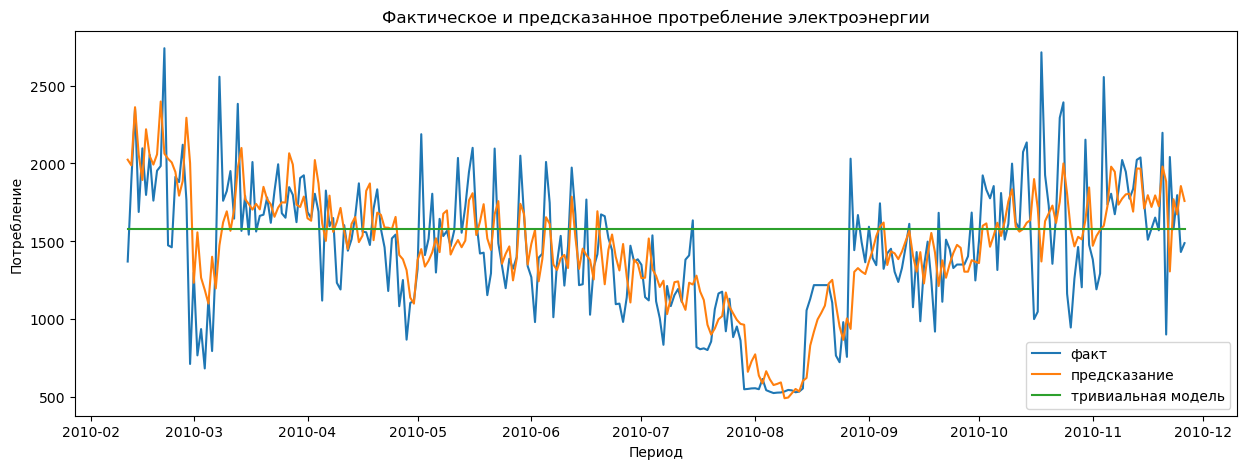

In [41]:
# визуализируем данные
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(target_test.index, target_test, label='факт')
ax.plot(target_test.index,  predict_с_test, label='предсказание')
ax.plot(target_test.index,  predict_t, label='тривиальная модель')
plt.legend()
plt.title('Фактическое и предсказанное протребление электроэнергии')
plt.xlabel("Период")
plt.ylabel("Потребление")
plt.show()

## Выводы

В ходе проделанной работы мы:

- изучили файл с данными
- Обучили модели - 'LightGBM','CatBoostRegressor','LinearRegression' и 'RandomForestRegressor'
- выяснили что лучше всего себя показала модель RandomForestRegressor 
- проверили модель на тестовой выборке
- оценили адекватность модели.